In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import ee
import geemap
# 导入相关库
import numpy as np
import matplotlib.pyplot as plt
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)
## 加载影像
# 去云、云阴影、雪掩膜函数
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    return image.updateMask(mask)
# landsat影像可视化参数
visParams = {
    'bands': ['B5', 'B6', 'B4'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .map(maskL8sr)
Map.addLayer(landsat_images.mosaic().clip(roi),visParams,'landsat image')

In [4]:
# 加载样本集
samples = ee.FeatureCollection('users/311605001111/wuhan_2020')
print(samples.size().getInfo())
# 在样本集中，各类样本的个数
clt_water = samples.filter(ee.Filter.eq('waterclass',1))
print(clt_water.size().getInfo())
clt_nowater = samples.filter(ee.Filter.eq('waterclass',0))
print(clt_nowater.size().getInfo())

4952
1084
3868


# 计算筛选掉的样本集

In [5]:
# K_mean聚类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
clusterer = ee.Clusterer.wekaKMeans(2).train(samples,bands)
result = samples.cluster(clusterer)
# print(result.first().getInfo())

#聚类后的水体
clt_water = result.filter(ee.Filter.eq('cluster',0))
print("聚类后的水体样本个数：",clt_water.size().getInfo())
# Map.addLayer(clt_water,{'color': '7CFC00', 'pointSize': 4,'fillColor': '7CFC00'},"clt_water")
#聚类后的非水体
clt_nowater = result.filter(ee.Filter.eq('cluster',1))
print("聚类后的非水体样本个数：",clt_nowater.size().getInfo())
# Map.addLayer(clt_nowater,{'color': 'f40101ff', 'pointSize': 4,'fillColor': 'ef0b0b56'},"clt_nowater")

# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft

right = result.map(Compare).filter(ee.Filter.eq('eq',0))
print(right.size().getInfo())
# Map.addLayer(right,{'color': 'FF8C00', 'pointSize': 4,'fillColor': 'FF8C00'},"right")
error = result.map(Compare).filter(ee.Filter.eq('eq',1))
print(error.size().getInfo())
# Map.addLayer(error,{'color': 'FF00FF', 'pointSize': 4,'fillColor': 'FF00FF'},"error")

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [115.06952397604292, 29.89721575640495]}, 'id': '0000000000000000001a', 'properties': {'AWEI': -2945, 'B2': 548, 'B3': 765, 'B4': 794, 'B5': 1570, 'B6': 1810, 'B7': 1342, 'CWI': 0.422651933701657, 'EVI': 0.871910112359551, 'EWI': -0.630880579010856, 'Image_id': 'LANDSAT/LC08/C01/T1_SR/LC08_122039_20200218', 'NDVI': 0.328257191201354, 'NDWI': -0.34475374732334, 'cluster': 1, 'mNDWI': -0.405825242718447, 'waterclass': 0}}


In [8]:
# 过滤后的样本
filtered_sample1 = ee.Algorithms.If(right.size().gt(error.size()),right,error)
print("筛选后，剩余的样本数： ",ee.FeatureCollection(filtered_sample1).size().getInfo())

land1 = ee.FeatureCollection(filtered_sample1).filter(ee.Filter.eq('waterclass',0))
print("筛选后样本中，非水体的个数： ",land1.size().getInfo())
water1 = ee.FeatureCollection(filtered_sample1).filter(ee.Filter.eq('waterclass',1))
print("筛选后样本中，水体的个数： ",water1.size().getInfo())

# land1_random = land1.randomColumn().filter(ee.Filter.lt('random', 0.01))  # 15 
# water1_random = water1.randomColumn().filter(ee.Filter.lt('random', 0.02)) # 14
# # print(water1_random.size().getInfo())

筛选后，剩余的样本数：  4920
筛选后样本中，非水体的个数：  3842
筛选后样本中，水体的个数：  1078


In [14]:
# 过滤后的样本
filtered_sample = ee.Algorithms.If(right.size().lt(error.size()),right,error)
print("筛选掉的样本数： ",ee.FeatureCollection(filtered_sample).size().getInfo())

land = ee.FeatureCollection(filtered_sample).filter(ee.Filter.eq('waterclass',0))
print("筛选掉的样本中，非水体的个数： ",land.size().getInfo())
water = ee.FeatureCollection(filtered_sample).filter(ee.Filter.eq('waterclass',1))
print("筛选掉的样本中，水体的个数： ",water.size().getInfo())


筛选掉的样本数：  32
筛选掉的样本中，非水体的个数：  26
筛选掉的样本中，水体的个数：  6


# 绘制散点图

In [ ]:
# 样本总数
filtered_sample1 = ee.FeatureCollection(filtered_sample1)
# samples 只初始样本
filtered_sample = samples
print(filtered_sample.size().getInfo())
# filtered_sample = ee.FeatureCollection(filtered_sample)
x = 'B3'
y = 'B6'
# 过滤后的样本
land_x1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo())
land_y1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
water_x1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
# 过滤diao的样本
land_x = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo())
land_y = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
water_x = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 

plt.figure(figsize=(8, 6))
plt.scatter(water_x,water_y,s=3,c='blue', label = 'water')
plt.scatter(land_x,land_y,s=3,c='red', label = 'land')
# plt.scatter(water_x1,water_y1,s=3,c='blue', label = 'retain_water')
# plt.scatter(land_x1,land_y1,s=3,c='red', label = 'retain_land')

plt.xlabel(x)    
plt.ylabel(y)
# plt.xlim(0,6300)
# plt.ylim(-100,2700)
# plt.title('B4/B5--remain')
# B3/B6
plt.xlim(0,2400)
plt.ylim(-100,4000)
plt.tick_params(labelsize=18)

plt.xlabel(x,fontsize=25)    
plt.ylabel(y,fontsize=25)

plt.title('B3/B6',fontsize=27)
plt.legend(prop={'size':18},markerscale=6)
# loc = 'upper right'
plt.show()

In [ ]:
# 样本总数
filtered_sample1 = ee.FeatureCollection(filtered_sample1)
filtered_sample = ee.FeatureCollection(filtered_sample)
x = 'B3'
y = 'B6'
# 过滤后的样本
land_x1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo())
land_y1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
water_x1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 = np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
# 过滤diao的样本
land_x = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo())
land_y = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
water_x = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 

plt.figure(figsize=(8, 6))
plt.scatter(water_x,water_y,s=5,c='blue', label = 'filter_water')
plt.scatter(land_x,land_y,s=5,c='red', label = 'filter_land')
plt.scatter(water_x1,water_y1,s=2,c='#7fb80e', label = 'remain_water')
plt.scatter(land_x1,land_y1,s=2,c='#9e17d6', label = 'remain_land')

plt.xlabel(x)    
plt.ylabel(y)
# plt.xlim(0,6300)
# plt.ylim(-100,2700)
# plt.title('B4/B5--remain')
plt.xlim(0,2400)
plt.ylim(-100,4000)
plt.title('B3/B6')
plt.legend(prop={'size':11},markerscale=3,loc = 'upper right')
plt.show()

32


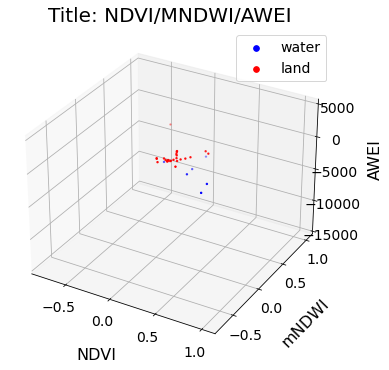

In [15]:
# %matplotlib notebook
## 数据
# 样本总数
filtered_sample1 = ee.FeatureCollection(filtered_sample1)
filtered_sample = ee.FeatureCollection(filtered_sample)
print(filtered_sample.size().getInfo())
x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'
# 全部样本
land_x1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z1 =np.array(filtered_sample1.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

land_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

# 创建一个三维的绘图工程
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x, water_y, water_z, s=2, c='blue', label = 'water')
ax.scatter(land_x, land_y, land_z, s=2,c='red', label = 'land')  

# ax.scatter(water_x1, water_y1, water_z1, s=2, c='blue', label = 'retian_water')
# ax.scatter(land_x1, land_y1, land_z1, s=2,c='red', label = 'retain_land')  

# 坐标轴
ax.set_xlim3d(-0.85,1.1)
ax.set_ylim3d(-0.8,1.1)
ax.set_zlim3d(-15000,5300)
plt.tick_params(labelsize=14)
ax.set_xlabel(x,labelpad = 16,fontsize = 16)
ax.set_ylabel(y,labelpad = 16,fontsize = 16)
ax.set_zlabel(z,labelpad = 16,rotation=90,fontsize = 16)
plt.xticks([-0.5,0,0.5,1.0])
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/MNDWI/AWEI',fontsize = 20) 
plt.legend(loc='upper right',markerscale=4,prop={'size':14})
plt.show()

# 绘制折线图

##  过滤掉的

In [ ]:
print(water.size().getInfo())
# 过滤掉的样本点中水体的光谱曲线特征
water_B2 = ee.List(water.aggregate_array('B2')).getInfo()
water_B3 = ee.List(water.aggregate_array('B3')).getInfo()
water_B4 = ee.List(water.aggregate_array('B4')).getInfo()
water_B5 = ee.List(water.aggregate_array('B5')).getInfo()
water_B6 = ee.List(water.aggregate_array('B6')).getInfo()
water_B7 = ee.List(water.aggregate_array('B7')).getInfo()

x = [1,2,3,4,5,6]
for i in range(water.size().getInfo()):
    a = []
    a.extend((water_B2[i]/10000,water_B3[i]/10000,water_B4[i]/10000,water_B5[i]/10000,water_B6[i]/10000,water_B7[i]/10000))
    plt.plot(x,a,'b-',linewidth=0.5)
plt.xticks(ticks=[1,2,3,4,5,6],labels=['B2','B3','B4','B5','B6','B7'],fontsize=12)
plt.yticks(fontsize=11)
plt.ylim(0,0.55)
plt.legend(['filter water'],prop={'size':15})
plt.xlabel('Band',fontsize=13)
plt.ylabel("Surface reflectance",fontsize=14)
plt.title("the spectral curve of water in filter sample",fontsize=16) 
# plt.title("the spectral curve of water in filter sample",fontdict = {'fontsize':10}) 

In [ ]:
land_random = land.randomColumn(seed=1).filter(ee.Filter.lt('random', 0.07))  # 7
print(land_random.size().getInfo())

# 过滤掉的样本点中陆地的光谱曲线特征
land_B2 = ee.List(land_random.aggregate_array('B2')).getInfo()
land_B3 = ee.List(land_random.aggregate_array('B3')).getInfo()
land_B4 = ee.List(land_random.aggregate_array('B4')).getInfo()
land_B5 = ee.List(land_random.aggregate_array('B5')).getInfo()
land_B6 = ee.List(land_random.aggregate_array('B6')).getInfo()
land_B7 = ee.List(land_random.aggregate_array('B7')).getInfo()

x = [1,2,3,4,5,6]
for i in range(land_random.size().getInfo()):
    a = []
    a.extend((land_B2[i]/10000,land_B3[i]/10000,land_B4[i]/10000,land_B5[i]/10000,land_B6[i]/10000,land_B7[i]/10000))
    plt.plot(x,a,'r-',linewidth=0.5)
plt.xticks(ticks=[1,2,3,4,5,6],labels=['B2','B3','B4','B5','B6','B7'],fontsize=12)
plt.yticks(fontsize=11)
plt.ylim(0,0.55)
plt.legend(['filter land'],prop={'size':15})
plt.xlabel('Band',fontsize=13)
plt.ylabel("Surface reflectance",fontsize=14)
plt.title("the spectral curve of land in filter sample",fontsize=16) 

In [ ]:
number = ee.Algorithms.If(ee.Number(land_random.size()).gt(ee.Number(water.size())),ee.Number(water.size()),ee.Number(land_random.size()))
print(number.getInfo())  

water_B2 = ee.List(water.aggregate_array('B2')).getInfo()
water_B3 = ee.List(water.aggregate_array('B3')).getInfo()
water_B4 = ee.List(water.aggregate_array('B4')).getInfo()
water_B5 = ee.List(water.aggregate_array('B5')).getInfo()
water_B6 = ee.List(water.aggregate_array('B6')).getInfo()
water_B7 = ee.List(water.aggregate_array('B7')).getInfo()

land_B2 = ee.List(land_random.aggregate_array('B2')).getInfo()
land_B3 = ee.List(land_random.aggregate_array('B3')).getInfo()
land_B4 = ee.List(land_random.aggregate_array('B4')).getInfo()
land_B5 = ee.List(land_random.aggregate_array('B5')).getInfo()
land_B6 = ee.List(land_random.aggregate_array('B6')).getInfo()
land_B7 = ee.List(land_random.aggregate_array('B7')).getInfo()

x = [1,2,3,4,5,6]
for i in range(number.getInfo()):
    a = []
    a.extend((water_B2[i]/10000,water_B3[i]/10000,water_B4[i]/10000,water_B5[i]/10000,water_B6[i]/10000,water_B7[i]/10000))
    b = []
    b.extend((land_B2[i]/10000,land_B3[i]/10000,land_B4[i]/10000,land_B5[i]/10000,land_B6[i]/10000,land_B7[i]/10000))    
    plt.plot(x,a,'b-',linewidth=0.5)
    plt.plot(x,b,'r-',linewidth=0.5)
plt.xticks(ticks=[1,2,3,4,5,6],labels=['B2','B3','B4','B5','B6','B7'],fontsize=12)
plt.yticks(fontsize=11)
plt.ylim(0,0.55)
plt.legend(['filter water','filter land'],prop={'size':15})
plt.xlabel('Band',fontsize=13)
plt.ylabel("Surface reflectance",fontsize=14)
plt.title("the spectral curve of land and water in filter sample",fontsize=14.5)

## 过滤后的

In [ ]:
land1_random = land1.randomColumn(seed=1).filter(ee.Filter.lt('random', 0.02))  # 15 
print(land1_random.size().getInfo())
water1_random = water1.randomColumn(seed=1).filter(ee.Filter.lt('random', 0.03)) # 14
print(water1_random.size().getInfo())

number1 = ee.Algorithms.If(ee.Number(land1_random.size()).gt(ee.Number(water1_random.size())),ee.Number(water1_random.size()),ee.Number(land1_random.size()))
print(number1.getInfo())                    

In [ ]:
# 过滤后的样本点中水体的光谱曲线特征
water_B2 = ee.List(water1_random.aggregate_array('B2')).getInfo()
water_B3 = ee.List(water1_random.aggregate_array('B3')).getInfo()
water_B4 = ee.List(water1_random.aggregate_array('B4')).getInfo()
water_B5 = ee.List(water1_random.aggregate_array('B5')).getInfo()
water_B6 = ee.List(water1_random.aggregate_array('B6')).getInfo()
water_B7 = ee.List(water1_random.aggregate_array('B7')).getInfo()

x = [1,2,3,4,5,6]
for i in range(water1_random.size().getInfo()):
    a = []
    a.extend((water_B2[i]/10000,water_B3[i]/10000,water_B4[i]/10000,water_B5[i]/10000,water_B6[i]/10000,water_B7[i]/10000))
    plt.plot(x,a,'b-',linewidth=0.5)
plt.xticks(ticks=[1,2,3,4,5,6],labels=['B2','B3','B4','B5','B6','B7'],fontsize=12)
plt.yticks(fontsize=11)
plt.ylim(0,0.55)
plt.legend(['remain water'],prop={'size':15})
plt.xlabel('Band',fontsize=13)
plt.ylabel("Surface reflectance",fontsize=14)
plt.title("the spectral curve of water in remain sample",fontsize=16) 

In [ ]:
# 过滤后的样本点中陆地的光谱曲线特征
land_B2 = ee.List(land1_random.aggregate_array('B2')).getInfo()
land_B3 = ee.List(land1_random.aggregate_array('B3')).getInfo()
land_B4 = ee.List(land1_random.aggregate_array('B4')).getInfo()
land_B5 = ee.List(land1_random.aggregate_array('B5')).getInfo()
land_B6 = ee.List(land1_random.aggregate_array('B6')).getInfo()
land_B7 = ee.List(land1_random.aggregate_array('B7')).getInfo()

x = [1,2,3,4,5,6]
for i in range(land1_random.size().getInfo()):
    a = []
    a.extend((land_B2[i]/10000,land_B3[i]/10000,land_B4[i]/10000,land_B5[i]/10000,land_B6[i]/10000,land_B7[i]/10000))
    plt.plot(x,a,'r-',linewidth=0.5)
plt.xticks(ticks=[1,2,3,4,5,6],labels=['B2','B3','B4','B5','B6','B7'],fontsize=12)
plt.yticks(fontsize=11)
plt.ylim(0,0.55)
plt.legend(['remain land'],prop={'size':15})
plt.xlabel('Band',fontsize=13)
plt.ylabel("surface reflectance",fontsize=14)
plt.title("the spectral curve of land in filter sample",fontsize=16) 

In [ ]:
water_B2 = ee.List(water1_random.aggregate_array('B2')).getInfo()
water_B3 = ee.List(water1_random.aggregate_array('B3')).getInfo()
water_B4 = ee.List(water1_random.aggregate_array('B4')).getInfo()
water_B5 = ee.List(water1_random.aggregate_array('B5')).getInfo()
water_B6 = ee.List(water1_random.aggregate_array('B6')).getInfo()
water_B7 = ee.List(water1_random.aggregate_array('B7')).getInfo()

land_B2 = ee.List(land1_random.aggregate_array('B2')).getInfo()
land_B3 = ee.List(land1_random.aggregate_array('B3')).getInfo()
land_B4 = ee.List(land1_random.aggregate_array('B4')).getInfo()
land_B5 = ee.List(land1_random.aggregate_array('B5')).getInfo()
land_B6 = ee.List(land1_random.aggregate_array('B6')).getInfo()
land_B7 = ee.List(land1_random.aggregate_array('B7')).getInfo()

x = [1,2,3,4,5,6]
for i in range(number1.getInfo()):
    a = []
    a.extend((water_B2[i]/10000,water_B3[i]/10000,water_B4[i]/10000,water_B5[i]/10000,water_B6[i]/10000,water_B7[i]/10000))
    b = []
    b.extend((land_B2[i]/10000,land_B3[i]/10000,land_B4[i]/10000,land_B5[i]/10000,land_B6[i]/10000,land_B7[i]/10000))    
    plt.plot(x,a,'b-',linewidth=0.5)
    plt.plot(x,b,'r-',linewidth=0.5)
plt.xticks(ticks=[1,2,3,4,5,6],labels=['B2','B3','B4','B5','B6','B7'],fontsize=12)
plt.yticks(fontsize=11)
plt.ylim(0,0.55)
plt.legend(['remain water','remain land'],prop={'size':15})
plt.xlabel('Band',fontsize=13)
plt.ylabel("Surface reflectance",fontsize=14)
plt.title("the spectral curve of land and water in filter sample",fontsize=14.5)